In [1]:
import os
import tarfile
import numpy as np
import matplotlib.pyplot as plt

from discretize import TensorMesh

import SimPEG.electromagnetics.time_domain as tdem

from SimPEG.utils import mkvc, plot_1d_layer_model
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

In [2]:
import dill
input_data_dict = dill.load(open("input_data.pik", "rb"))

In [3]:
source_list = input_data_dict['source_list']
voltages_ch1 = input_data_dict['voltages_ch1']
voltages_ch2 = input_data_dict['voltages_ch2']
voltages_std_ch1 = input_data_dict['voltages_std_ch1']
voltages_std_ch2 = input_data_dict['voltages_std_ch2']

In [4]:
dobs = -np.r_[voltages_ch1, voltages_ch2]
std = np.r_[voltages_std_ch1, voltages_std_ch2]

In [5]:
survey = tdem.Survey(source_list)

In [6]:
# 5% of the absolute value
uncertainties = 0.05 * np.abs(dobs)
uncertainties[uncertainties<std] = std[uncertainties<std]
# Define the data object
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [7]:
times_ch1 = source_list[0].receiver_list[0].times
times_ch2 = source_list[1].receiver_list[0].times

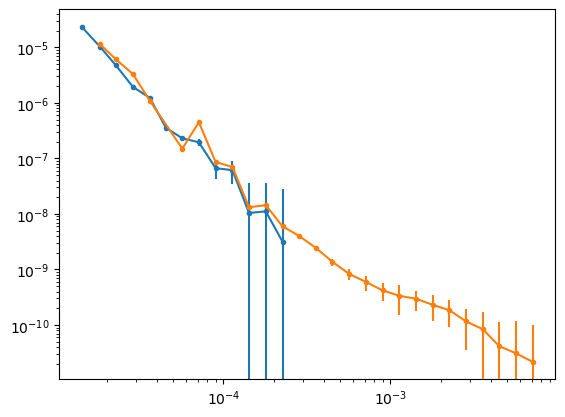

In [8]:
plt.errorbar(times_ch1, voltages_ch1,  uncertainties[:len(voltages_ch1)], marker='.')
plt.errorbar(times_ch2, voltages_ch2,  uncertainties[len(voltages_ch1):], marker='.')
plt.xscale('log')
plt.yscale('log')

In [9]:
# Layer thicknesses
inv_thicknesses = np.logspace(0, 1.5, 25)

# Define a mesh for plotting and regularization.
mesh = TensorMesh([(np.r_[inv_thicknesses, inv_thicknesses[-1]])], "0")

In [10]:
# Define model. A resistivity (Ohm meters) or conductivity (S/m) for each layer.
starting_model = np.log(0.01 * np.ones(mesh.nC))

# Define mapping from model to active cells.
model_mapping = maps.ExpMap()

In [11]:
simulation = tdem.Simulation1DLayered(
    survey=survey, thicknesses=inv_thicknesses, sigmaMap=model_mapping
)

In [12]:
dpred = simulation.dpred(starting_model)

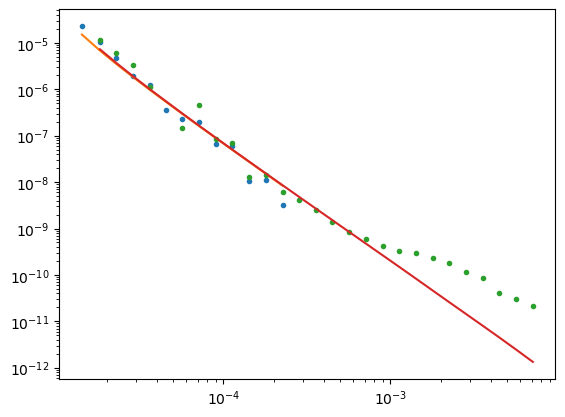

In [13]:
plt.plot(times_ch1, voltages_ch1, '.')
plt.plot(times_ch1, -dpred[:len(times_ch1)], '-')

plt.plot(times_ch2, voltages_ch2, '.')
plt.plot(times_ch2, -dpred[len(times_ch1):], '-')


plt.xscale('log')
plt.yscale('log')

In [14]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# The weighting is defined by the reciprocal of the uncertainties.
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)
dmis.W = 1.0 / uncertainties

# Define the regularization (model objective function)
reg_map = maps.IdentityMap(nP=mesh.nC)
reg = regularization.WeightedLeastSquares(mesh, mapping=reg_map, alpha_s=1e-10, alpha_x=1.0)

# set reference model
reg.reference_model = starting_model

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(maxIter=10, maxIterLS=20, maxIterCG=30, tolCG=1e-3)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1)
beta_schedule = directives.BetaSchedule(coolingFactor=2., coolingRate=1)
target = directives.TargetMisfit(chifact=1.)
# Options for outputting recovered models and predicted data for each beta.
save_dict = directives.SaveOutputDictEveryIteration()

# The directives are defined as a list.
directives_list = [
    starting_beta,
    save_dict,
    beta_schedule,
    target
]
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.84e+02  5.86e+02  0.00e+00  5.86e+02    3.70e+02      0              
   1  1.42e+02  5.23e+02  4.50e-02  5.29e+02    1.03e+03      0              
   2  7.11e+01  2.62e+02  5.19e-02  2.65e+02    8.34e+01      0              
   3  3.56e+01  2

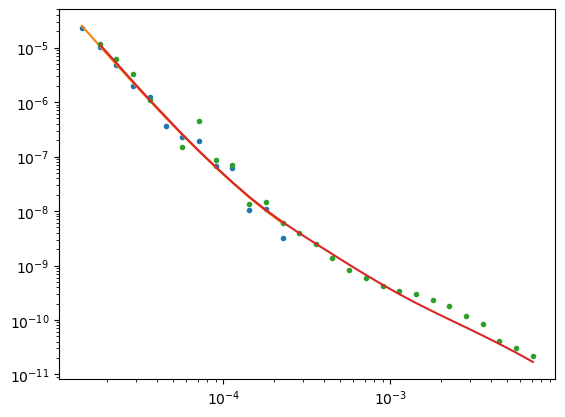

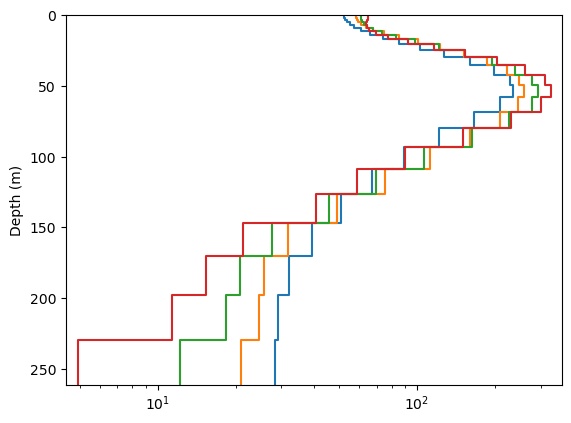

In [30]:
fig, ax = plt.subplots(1,1)
for kk in range(1,5):
    sigma = model_mapping * save_dict.outDict[kk]['m']
    plot_1d_layer_model(inv_thicknesses, 1./sigma, ax=ax)

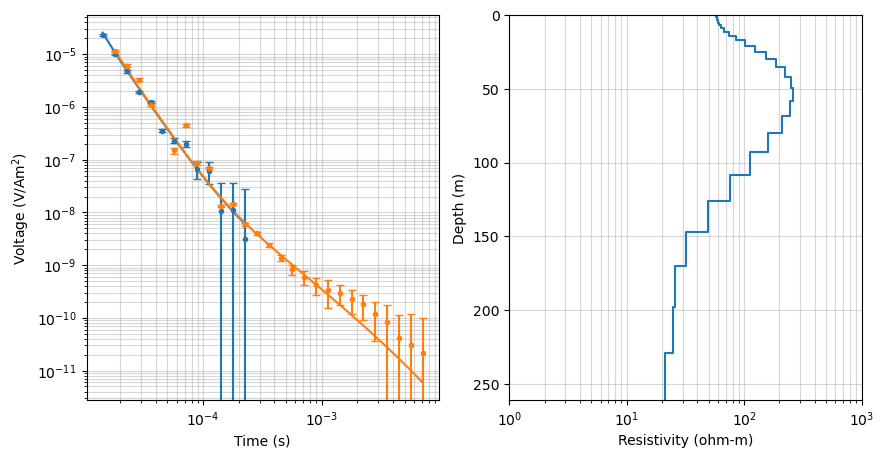

In [53]:
fig, axs = plt.subplots(1,2, figsize=(10, 5))
iteration = 2
sigma = model_mapping * save_dict.outDict[iteration]['m']
dpred = save_dict.outDict[iteration]['dpred']

ax1, ax2 = axs
ax1.errorbar(times_ch1, voltages_ch1,  uncertainties[:len(voltages_ch1)], marker='.', linestyle='None', color='C0', capsize=3)
ax1.errorbar(times_ch2, voltages_ch2,  uncertainties[len(voltages_ch1):], marker='.', linestyle='None', color='C1', capsize=3)

ax1.loglog(times_ch1, -dpred[:len(times_ch1)], '-', color='C0')
ax1.loglog(times_ch2, -dpred[len(times_ch1):], '-', color='C1')

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Voltage (V/Am$^2$)")
plot_1d_layer_model(inv_thicknesses, 1./sigma, ax=ax2)
ax2.set_xlabel("Resistivity (ohm-m)")
ax2.set_xlim(1, 1000)

for ax in axs:
    ax.grid(True, which='both', alpha=0.5)